In [28]:
import pysal
import geopandas as gpd
import arcpy
from pysal.model import mgwr
import pandas as pd
import os
import datetime as dt 
from pprint import pprint # Pretty printing
import seaborn as sns # better plotting
import matplotlib.pyplot as plt # basic plotting
from matplotlib import colors # For colormap creation 


In [18]:
# Load Csv's 

cwd = os.getcwd()

data_path = os.path.join(cwd,'..', '..', 'data')
arcpy.env.workspace = os.path.join(cwd, '..', '..', 'data', 'QAQC.gdb')

modeling_df = pd.read_csv(os.path.join(data_path, 'Parameter_df.csv'))

modeling_df['date'] = pd.to_datetime(modeling_df.date)

In [19]:
# Get previous day

previous_dates = modeling_df.date.dt.date - dt.timedelta(1)

for i, row in modeling_df.iterrows():
    
    previous_date = previous_dates.loc[i]
    
    sensor_id = row.sensor_index
    
    previous_readings = modeling_df[(modeling_df.date.dt.date == previous_date)&
                                   (modeling_df.sensor_index == sensor_id)].pm25_fullDay_mean
    
    if len(previous_readings) == 1:

        modeling_df.loc[i, 'pm25_fullDay_mean_yesterday'] = previous_readings.iloc[0]

    
modeling_df.head()

,sensor_index,date,is_weekday,n_observations,pm25_fullDay_mean,pm25_fullDay_minutesAbove12ug,n_spikes,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean,idwSum_facilities,idwSum_traffic,pm25_fullDay_mean_yesterday
0,143656,2023-03-18,0,144,5.341125,190,0,45.833,23.505,988.205,0.005054,861.930809,4.240750
1,142774,2022-11-05,0,144,8.901722,370,0,62.438,42.682,973.451,0.004609,452.986261,13.551993
2,145454,2022-12-06,1,144,11.355750,690,2,48.174,26.181,987.556,67.350629,587.483355,8.880667
3,142748,2022-12-07,1,144,11.848437,560,3,53.589,25.477,994.330,2.827060,3827.349398,7.053014
4,143636,2023-01-22,0,144,24.739590,1440,50,60.596,28.776,983.963,24.669941,453.501189,13.688465


In [20]:
# Definitions

# Spatial Join

%run merge_dataFrame_w_featureClass.py

help(merge_dataFrame_w_featureClass)

Help on function merge_dataFrame_w_featureClass in module __main__:

merge_dataFrame_w_featureClass(df, fc_name, new_name, left_on, right_on, field_types)
    df should be a pandas dataframe
    fc_name should be a string referring to a feature class in your GDB
    new_name should be a string for the new feature class
    left_on should be the field to merge from on the featureClass
    right_on should be the column to merge from the dataframe
    field_types should be a list of ESRI field types - 
    see https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-fields.htm



In [21]:
# Clean data

no_nans = modeling_df.dropna().copy()

no_nans['month'] = no_nans.date.dt.month.astype(str)

print(len(no_nans), len(modeling_df))

len(no_nans.sensor_index.unique())

9857 10372


54

In [22]:
# Define important variables

y_name = 'pm25_fullDay_mean' # Dependent

y_type = 'FLOAT'

x_names = [ # Independents
    'humidity_fullDay_mean', 
           'pm25_fullDay_mean_yesterday',
            'temperature_fullDay_mean',
           'pressure_fullDay_mean',
           # 'idwSum_facilities', 'idwSum_traffic'
    ]

x_types = ['FLOAT'] * len(x_names)

In [23]:
cols = ['sensor_index'] + [y_name] + x_names
select_weekday = no_nans[(no_nans.is_weekday == 1)][cols]

In [24]:
stations_df = pd.read_csv('stations_5-2.csv')
merged_df = pd.merge(stations_df, select_weekday, on='sensor_index')

In [25]:
import numpy as np
no_nans = merged_df.dropna().copy()
coords = np.array(list(zip(no_nans.longitude, no_nans.latitude)))
y = no_nans.pm25_fullDay_mean.values.reshape(-1, 1)
X = no_nans[x_names].values
# s.reshape(-1, 1)
bw = 0.1

In [26]:
m1 = mgwr.gwr.GWR(coords = coords,
y = y,
X = X,
fixed = True,
bw = bw)


results = m1.fit()

results.summary()

Model type                                                         Gaussian
Number of observations:                                                7004
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         615448.878
Log-likelihood:                                                  -25612.744
AIC:                                                              51235.488
AICc:                                                             51237.500
BIC:                                                             553478.076
R2:                                                                   0.492
Adj. R2:                                                              0.491

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [40]:
def plot_GWR(data, results, predictors, title):
    '''This function will plot GWR Results and save the figure'''
    
    # Plot Betas and R^2

    betas = results.params # Coefficients from model
    
    n_plots = betas.shape[1] + 1
    
    if n_plots == 4:
        f,axs=plt.subplots(2,2, figsize=(18,18),subplot_kw=dict(aspect='equal')) # initialize a figure
    elif n_plots == 6:
        f, axs = plt.subplots(2,3, figsize = (27,18), subplot_kw=dict(aspect='equal'))
    else:
        f,axs=plt.subplots(3,n_plots, figsize=(18,6),subplot_kw=dict(aspect='equal')) # initialize a figure

    for i, ax in enumerate(axs.flatten()): # Loop through subplots

        if i == len(predictors) + 1: break # Break out of loop for final plot (R^2)

        db_to_plot = data.assign(beta_i = betas.T[i]) # Assign beta_i's to original dataframe
        
        vmin = min(betas.T[i])
        vmax = max(betas.T[i])
        
        if vmin < 0 and vmax > 0:
            vcenter = 0
        else:
            vcenter = np.median(betas.T[i])

        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        
        db_to_plot.plot(column='beta_i',cmap='PiYG',marker='.',ax=ax,legend=True, norm = norm, s=500) # Plot beta_i's
        # Add colorbar, make sure to specify tick locations to match desired ticklabels

        # base map
        # ctx.add_basemap(ax, 
        #             crs=data.crs, 
        #             source=ctx.providers.Stamen.TonerHybrid,
        #             zorder=-1, # plot behind all other plots
        #             alpha=0.5
        #            )

        # set the title of the plot to be the name of the variable:
        if i==0:
            ax.set_title(r'$\beta$ of Constant',fontsize=16)
        else: 
            ax.set_title(r'$\beta$ of '+ predictors[i-1],fontsize=16)
        ax.set_axis_off() # Remove Axis labels


    last_ax = axs.flatten()[-1] # Get last subplot

    rdata = data.assign(r2=results.localR2)

    rdata[rdata['r2'] > 0].plot(column='r2', cmap='Reds', ax = last_ax, legend=True, marker='.', s=500) # plot R^2 values

    # base map
    # ctx.add_basemap(ax = last_ax,
    #                 crs=select_sp.crs,
    #                 source=ctx.providers.Stamen.TonerHybrid,
    #                 zorder=-1,
    #                 alpha=0.5)

    # title/remove axes
    last_ax.set_title(r'local $R^2$',fontsize=16)
    last_ax.set_axis_off()


    f.tight_layout() # we are done!
    f.savefig(title)
    plt.show()

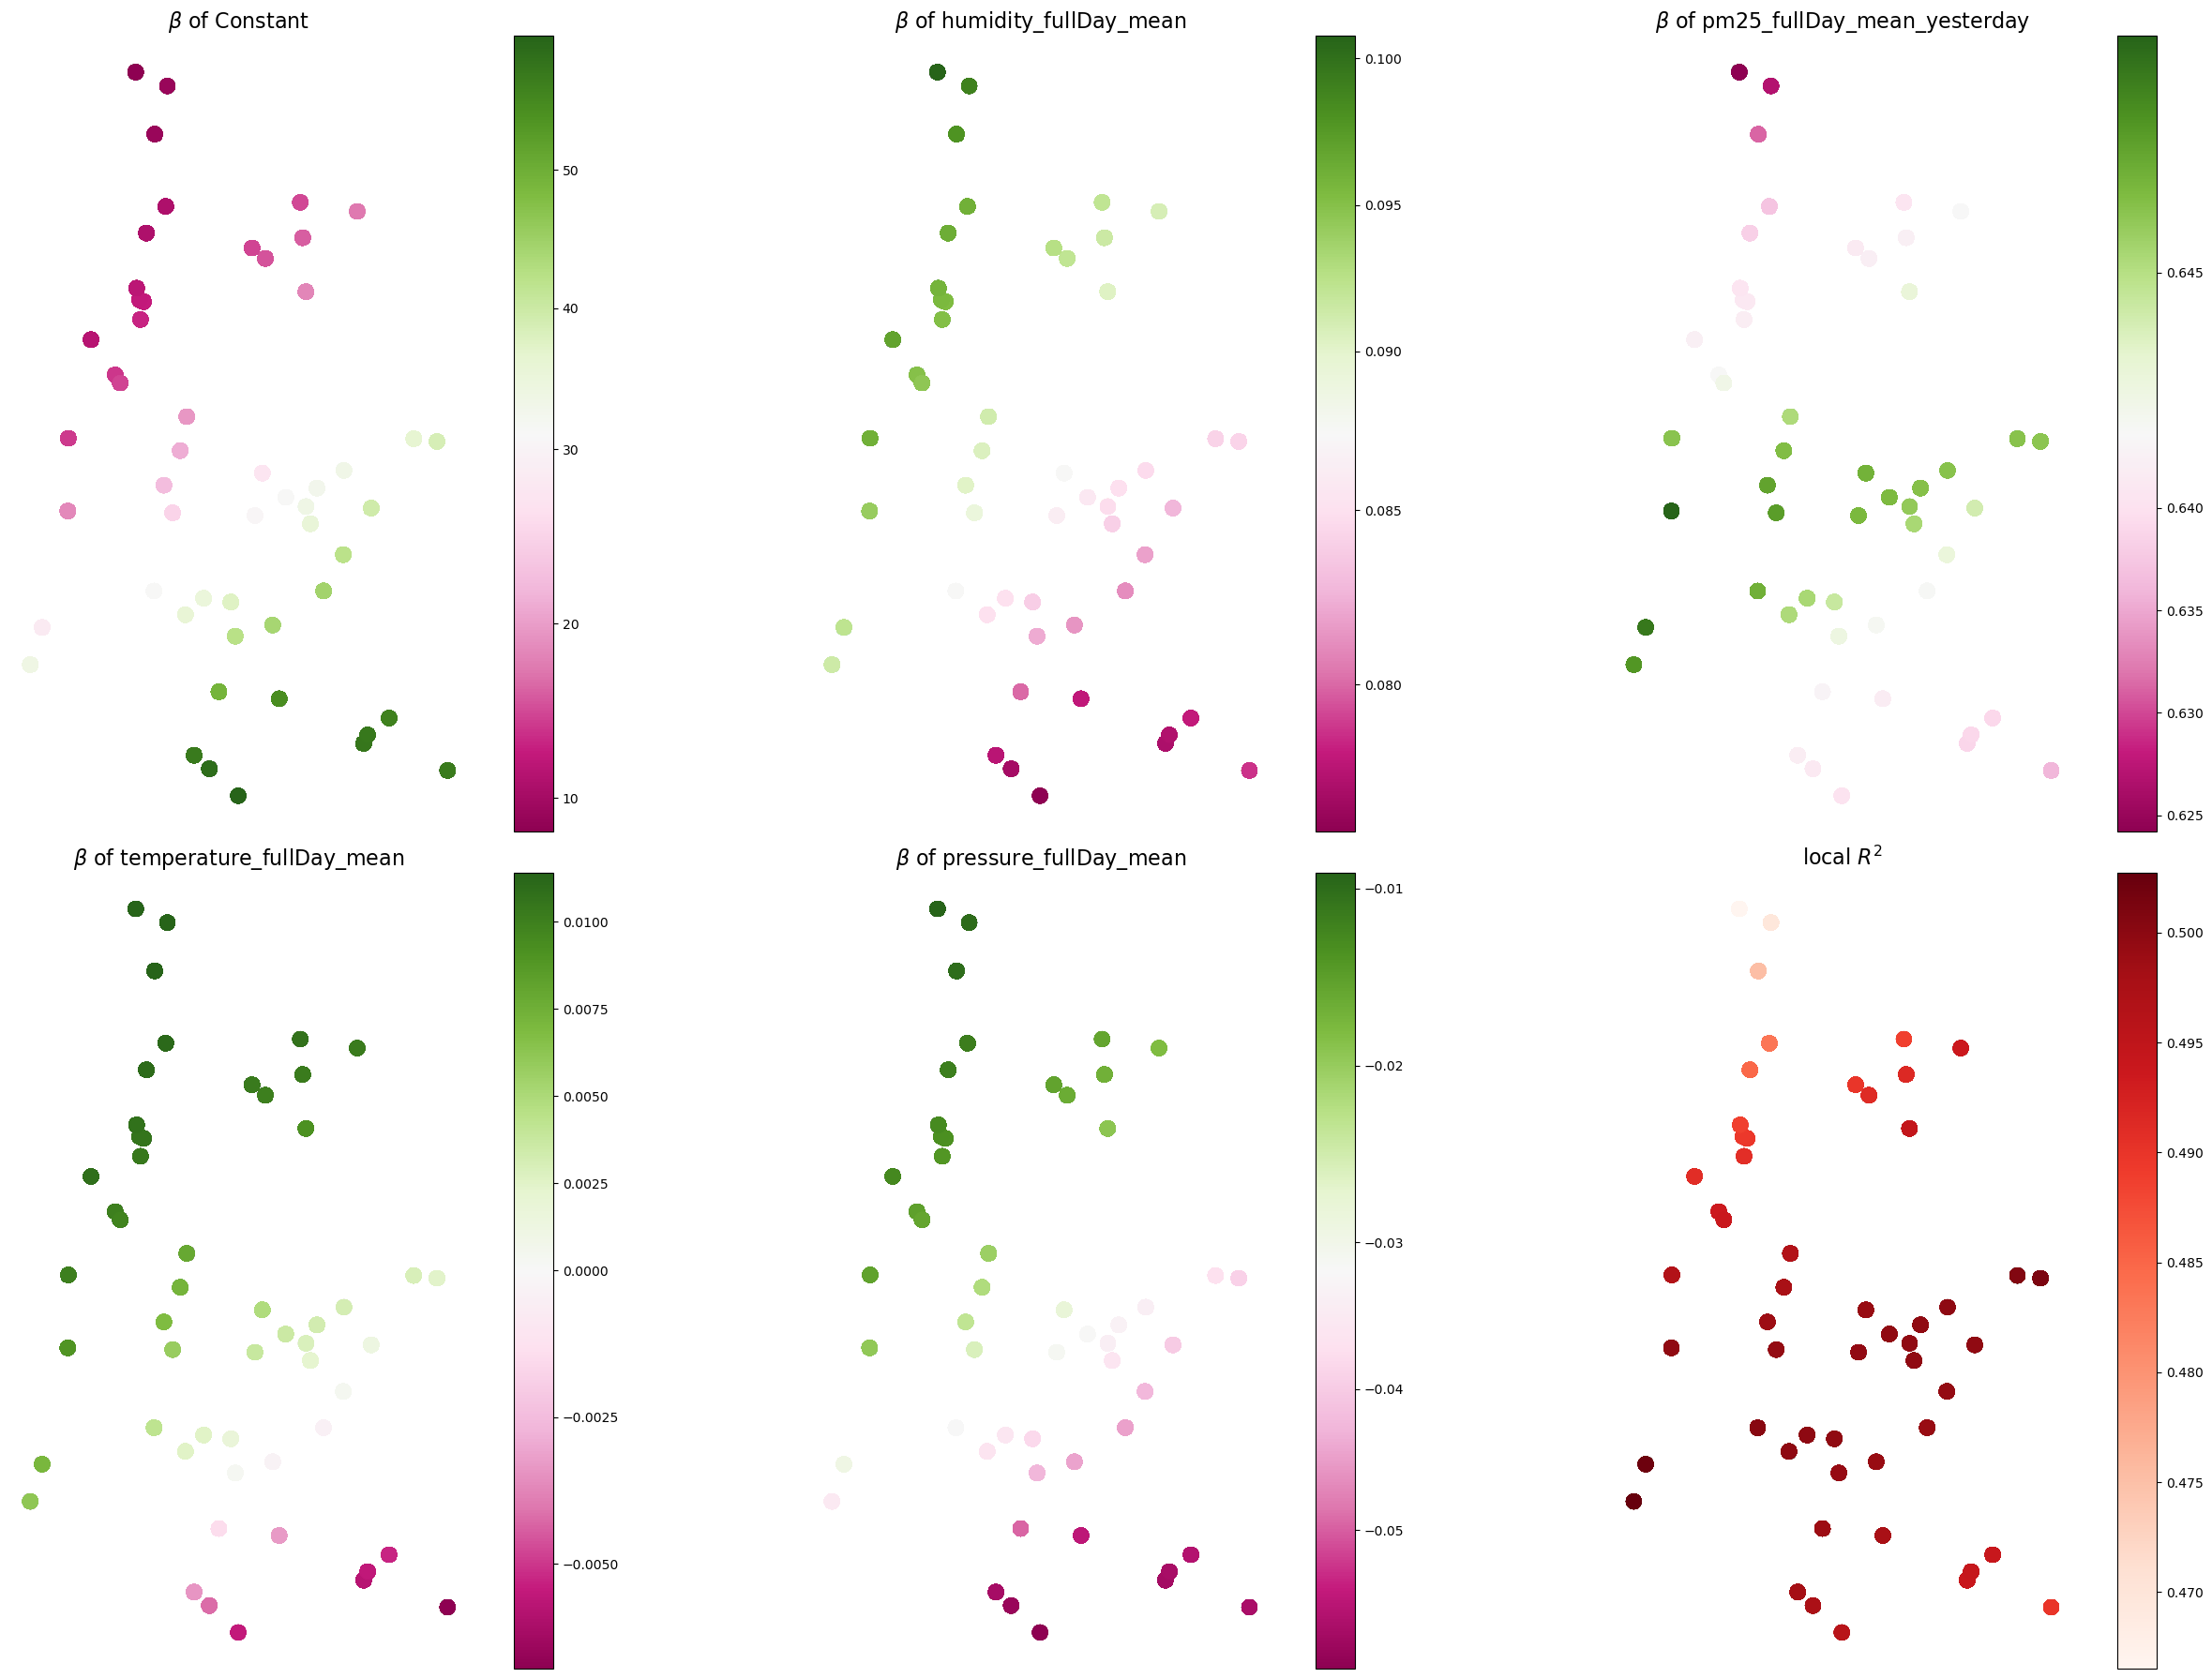

In [41]:
no_nans_gdf = gpd.GeoDataFrame(no_nans, geometry = gpd.points_from_xy(no_nans.longitude,
                                                                      no_nans.latitude,
                                                                      crs = 'EPSG:4326')
                              )


plot_GWR(no_nans_gdf, results, x_names, 'GWR')

In [44]:
x_names

['humidity_fullDay_mean',
 'pm25_fullDay_mean_yesterday',
 'temperature_fullDay_mean',
 'pressure_fullDay_mean']

In [53]:
# Let's forecast!?

humidity = 85
pm_yesterday = 12
temp = 75
pressure = 930

init_params = np.array([1, humidity, pm_yesterday, temp, pressure])

forecast = np.sum(results.params * init_params, axis=1)

results.params.shape

(7004, 5)

In [49]:
len(merged_df.sensor_index.unique())

53